In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from PIL import Image
import shutil
from collections import Counter

# =========================================================================
# 1. MOUNT DRIVE & LOAD DATASET
# =========================================================================
print("🔗 Menghubungkan ke Google Drive...")
drive.mount('/content/drive')

PATH_TO_YOUR_DATASET_FOLDER = '/content/drive/MyDrive/jeruk_deepl'
base_dir = PATH_TO_YOUR_DATASET_FOLDER

if not os.path.isdir(base_dir):
    print(f"\n⚠️ ERROR: Direktori tidak ditemukan di {base_dir}")
    exit()
else:
    print(f"\n✅ Dataset ditemukan di: {base_dir}")

🔗 Menghubungkan ke Google Drive...
Mounted at /content/drive

✅ Dataset ditemukan di: /content/drive/MyDrive/jeruk_deepl


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import numpy as np
import os

# Set seed agar hasil bisa direproduksi (penting untuk debugging)
tf.random.set_seed(42)
np.random.seed(42)

# =========================================================================
# 1. PREPROCESSING & DATA GENERATOR (FIXED)
# =========================================================================
print("\n" + "="*60)
print("🔧 KONFIGURASI DATA (ResNet Standard)")
print("="*60)

# KEMBALIKAN KE SETTING STABIL
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"✅ Data Ready. Classes: {num_classes}")

# =========================================================================
# 2. FOCAL LOSS (FIXED VERSION)
# =========================================================================
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, name='focal_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = tf.pow(1 - p_t, self.gamma)
        focal_loss = self.alpha * focal_weight * ce
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def get_config(self):
        config = super().get_config()
        config.update({"gamma": self.gamma, "alpha": self.alpha})
        return config


🔧 KONFIGURASI DATA (ResNet Standard)
Found 803 images belonging to 3 classes.
Found 198 images belonging to 3 classes.
✅ Data Ready. Classes: 3


In [ ]:
# =========================================================================
# 3. MODEL ARCHITECTURE (PENYEBAB LOSS TINGGI DIPERBAIKI DISINI)
# =========================================================================
print("\n" + "="*60)
print("🏗️ MEMBANGUN MODEL (CLEAN ARCHITECTURE)")
print("="*60)

def build_clean_model(num_classes):
    base_model = ResNet50(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )

    # Unfreeze sedikit layer atas untuk adaptasi (Transfer Learning)
    base_model.trainable = True
    for layer in base_model.layers[:-30]: # Fine tune 30 layer terakhir cukup
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(512, activation='relu'), # Tanpa L2, loss akan turun drastis
        tf.keras.layers.BatchNormalization(),          # Stabilizer
        tf.keras.layers.Dropout(0.5),                  # Regularizer yang lebih aman daripada L2

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = build_clean_model(num_classes)
model.summary()

# =========================================================================
# 4. TRAINING SETUP (ADAPTIVE LEARNING RATE)
# =========================================================================
# Learning Rate: Mulai kecil, biar Adam adaptasi pelan-pelan
# Adaptive Learning Rate: ReduceLROnPlateau akan urus sisanya
initial_lr = 1e-4

model.compile(
    loss=FocalLoss(gamma=2.0, alpha=0.25), # Focal Loss aktif
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    metrics=['accuracy']
)

callbacks = [
    # Stop kalau gak ada improvement biar gak buang waktu
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,             # 10 epoch cukup, 20 kelamaan nunggu overfit
        restore_best_weights=True,
        verbose=1
    ),

    # INI ADAPTIVE LEARNING RATE (Kunci agar loss turun terus)
    # Kalau loss stuck 3 epoch, turunkan LR
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,             # Turun drastis biar masuk ke celah global minima
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    ModelCheckpoint(
        'best_model_final_fix.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


🏗️ MEMBANGUN MODEL (CLEAN ARCHITECTURE)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,387 (94.00 MB)

 Trainable params: 15,501,827 (59.13 MB)

 Non-trainable params: 9,138,560 (34.86 MB)

In [ ]:
print("\n" + "="*60)
print("🚀 MULAI TRAINING")
print("="*60)
print("Target: Val Loss < 1.0, Val Acc > 85%")

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


🚀 MULAI TRAINING
Target: Val Loss < 1.0, Val Acc > 85%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5347 - loss: 0.2629
Epoch 1: val_accuracy improved from -inf to 0.77273, saving model to best_model_final_fix.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 307s 11s/step - accuracy: 0.5386 - loss: 0.2602 - val_accuracy: 0.7727 - val_loss: 0.1056 - learning_rate: 1.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.7482 - loss: 0.1196
Epoch 2: val_accuracy did not improve from 0.77273
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 781ms/step - accuracy: 0.7492 - loss: 0.1189 - val_accuracy: 0.7576 - val_loss: 0.1028 - learning_rate: 1.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.8507 - loss: 0.0635
Epoch 3: val_accuracy did not improve from 0.77273
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 730ms/step - accuracy: 0.8505 - loss: 0.0636 - val_accuracy: 0.7576 - val_loss: 0.1114 - learning_rate: 1.0000e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8199 - loss: 0.0591
Epoch 4: val_accuracy im


🔄 Loading Model dengan Class Fixed...
✅ Model berhasil di-load! Error 'reduction' sudah fix.

📈 GRAFIK TRAINING & VALIDASI (CLEAN)


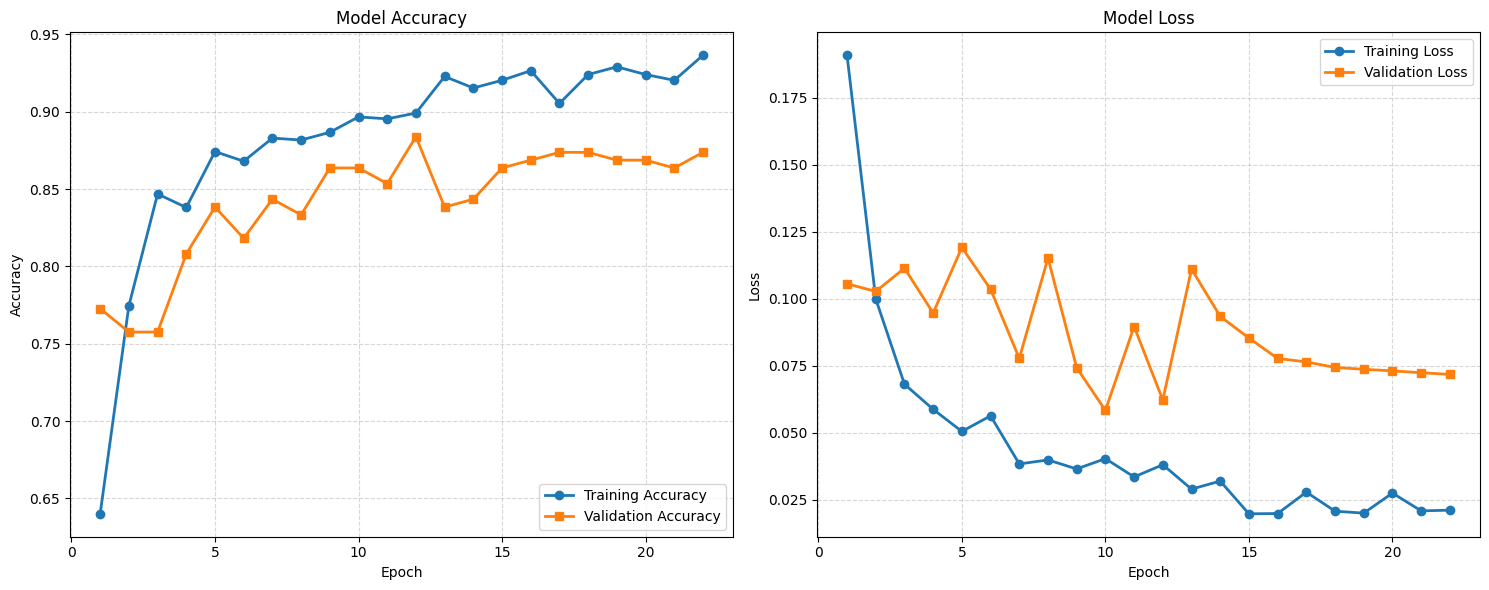


📊 Summary Angka:
   Best Validation Accuracy: 88.38% (Epoch 12)
   Lowest Validation Loss  : 0.0584 (Epoch 10)
Found 198 images belonging to 3 classes.

🎯 Menghitung Akurasi...
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 631ms/step - accuracy: 0.8231 - loss: 0.1117

📊 HASIL VALIDASI:
   Akurasi: 88.38%
   Loss   : 0.0623

🔮 Membuat Prediksi...
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

📋 Classification Report:
              precision    recall  f1-score   support

 jeruk_limau       0.89      0.74      0.81        66
 jeruk_nipis       0.79      0.94      0.86        66
 jeruk_purut       0.98      0.97      0.98        66

    accuracy                           0.88       198
   macro avg       0.89      0.88      0.88       198
weighted avg       0.89      0.88      0.88       198



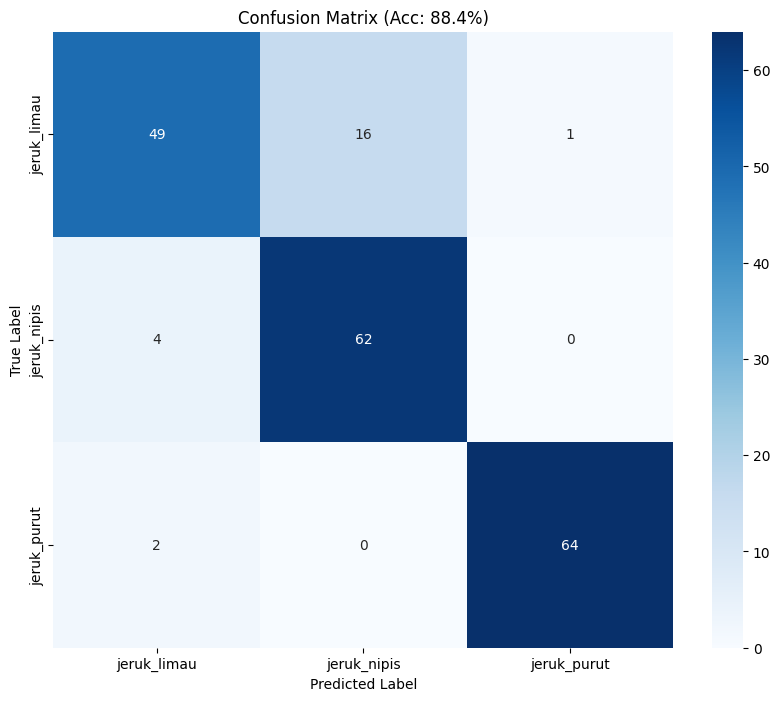


🔮 Sedang Melakukan Prediksi (Sabar yaa)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step

📋 LAPORAN KLASIFIKASI LENGKAP
              precision    recall  f1-score   support

 jeruk_limau       0.89      0.74      0.81        66
 jeruk_nipis       0.79      0.94      0.86        66
 jeruk_purut       0.98      0.97      0.98        66

    accuracy                           0.88       198
   macro avg       0.89      0.88      0.88       198
weighted avg       0.89      0.88      0.88       198



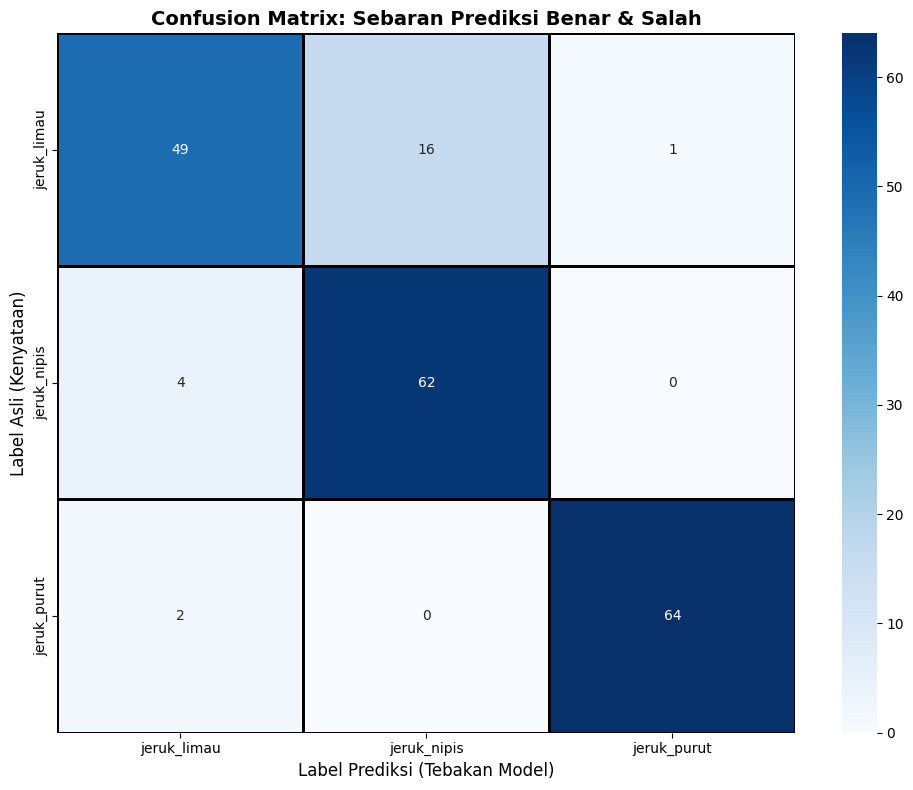


📊 GRAFIK PERBANDINGAN PERFORMA ANTAR JERUK


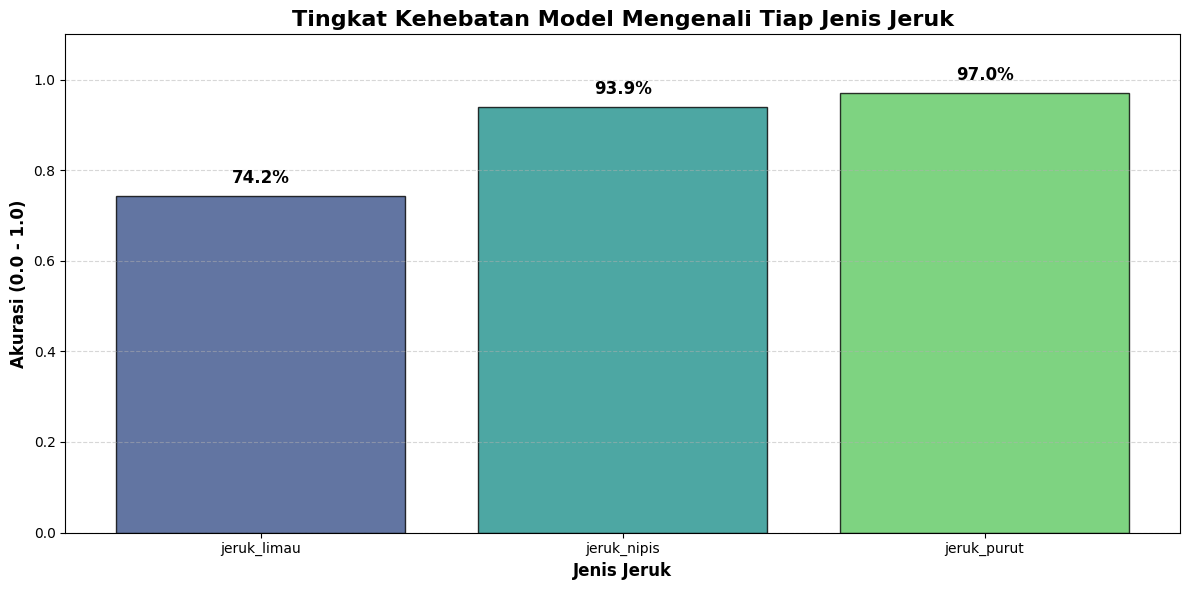

🏆 Juara 1: Jeruk **jeruk_purut** (Model paling paham sama jeruk ini!)
🧐 Perlu Belajar Lagi: Jeruk **jeruk_limau** (Agak susah bedain yang ini)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# =========================================================================
# 1. PERBAIKAN CLASS FOCAL LOSS (CRITICAL FIX)
# =========================================================================
class FocalLoss(tf.keras.losses.Loss):
    # Tambahkan **kwargs untuk menangkap argument 'reduction' dari Keras
    def __init__(self, gamma=2.0, alpha=0.25, name='focal_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = tf.pow(1 - p_t, self.gamma)
        focal_loss = self.alpha * focal_weight * ce
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    # Wajib ada agar config tersimpan/terbaca benar
    def get_config(self):
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# =========================================================================
# 2. LOAD MODEL (Sekarang pasti berhasil)
# =========================================================================
print("\n" + "="*60)
print("🔄 Loading Model dengan Class Fixed...")
print("="*60)

NEW_MODEL_PATH = 'best_model_final_fix.keras'

try:
    # Clear session dulu
    tf.keras.backend.clear_session()

    model = tf.keras.models.load_model(
        NEW_MODEL_PATH,
        custom_objects={'FocalLoss': FocalLoss}
    )
    print("✅ Model berhasil di-load! Error 'reduction' sudah fix.")

except Exception as e:
    print(f"❌ Masih Error: {e}")
    print("Saran: Pastikan path file benar.")

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# =========================================================================
# PLOT TRAINING HISTORY (CLEAN VERSION)
# =========================================================================
print("\n" + "="*60)
print("📈 GRAFIK TRAINING & VALIDASI (CLEAN)")
print("="*60)

if 'history' in globals():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))

    # ---------------------------------------------------------
    # 1. Plot Accuracy
    # ---------------------------------------------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s', linewidth=2)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)

    # ---------------------------------------------------------
    # 2. Plot Loss
    # ---------------------------------------------------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s', linewidth=2)
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print Text Summary Saja (Biar grafik bersih)
    best_acc = max(val_acc)
    best_epoch = val_acc.index(best_acc) + 1
    min_loss = min(val_loss)
    best_loss_epoch = val_loss.index(min_loss) + 1

    print(f"\n📊 Summary Angka:")
    print(f"   Best Validation Accuracy: {best_acc*100:.2f}% (Epoch {best_epoch})")
    print(f"   Lowest Validation Loss  : {min_loss:.4f} (Epoch {best_loss_epoch})")

else:
    print("❌ Variabel 'history' tidak ditemukan!")
    print("   Pastikan proses training (model.fit) sudah dijalankan sebelumnya.")

# =========================================================================
# 3. LANJUT KE EVALUASI (Code sama seperti sebelumnya)
# =========================================================================
if 'model' in globals():
    # Setup Data
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32

    # base_dir = '/content/dataset_jeruk' # Uncomment jika perlu

    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    validation_generator = val_datagen.flow_from_directory(
        base_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    labels_list = list(validation_generator.class_indices.keys())

    # Evaluasi
    print("\n🎯 Menghitung Akurasi...")
    val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
    print(f"\n📊 HASIL VALIDASI:")
    print(f"   Akurasi: {val_acc*100:.2f}%")
    print(f"   Loss   : {val_loss:.4f}")

    # Generate Predictions
    print("\n🔮 Membuat Prediksi...")
    validation_generator.reset()
    Y_pred = model.predict(validation_generator, verbose=1)
    y_pred_classes = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=labels_list))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_list, yticklabels=labels_list)
    plt.title(f'Confusion Matrix (Acc: {val_acc*100:.1f}%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# =========================================================================
# 3. EVALUASI LENGKAP + BAR CHART PERBANDINGAN KELAS
# =========================================================================

# Pastikan model sudah ada
if 'model' in globals() and 'validation_generator' in globals():

    # 1. Setup Ulang Generator (Biar urutannya pas dan fresh)
    print("\n🔮 Sedang Melakukan Prediksi (Sabar yaa)...")
    validation_generator.reset()

    # Ambil Prediksi
    Y_pred = model.predict(validation_generator, verbose=1)
    y_pred_classes = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes
    labels_list = list(validation_generator.class_indices.keys())

    # ---------------------------------------------------------------------
    # A. CLASSIFICATION REPORT
    # ---------------------------------------------------------------------
    print("\n" + "="*60)
    print("📋 LAPORAN KLASIFIKASI LENGKAP")
    print("="*60)
    print(classification_report(y_true, y_pred_classes, target_names=labels_list))

    # ---------------------------------------------------------------------
    # B. CONFUSION MATRIX (HEATMAP)
    # ---------------------------------------------------------------------
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_list, yticklabels=labels_list,
                linewidths=1, linecolor='black') # Aku tambahin garis biar tegas
    plt.title('Confusion Matrix: Sebaran Prediksi Benar & Salah', fontsize=14, fontweight='bold')
    plt.ylabel('Label Asli (Kenyataan)', fontsize=12)
    plt.xlabel('Label Prediksi (Tebakan Model)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------------------
    # C. BAR CHART PERBANDINGAN AKURASI PER KELAS 📊
    # ---------------------------------------------------------------------
    print("\n" + "="*60)
    print("📊 GRAFIK PERBANDINGAN PERFORMA ANTAR JERUK")
    print("="*60)

    # Hitung akurasi per kelas (Diagonal CM dibagi Total per Baris)
    # Ini rumus: Berapa persen dia bener nebak jeruk A dari total jeruk A yang ada
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(12, 6))

    colors = sns.color_palette("viridis", len(labels_list))
    bars = plt.bar(labels_list, class_accuracies, color=colors, edgecolor='black', alpha=0.8)

    # Hiasan Grafik
    plt.title('Tingkat Kehebatan Model Mengenali Tiap Jenis Jeruk', fontsize=16, fontweight='bold')
    plt.xlabel('Jenis Jeruk', fontsize=12, fontweight='bold')
    plt.ylabel('Akurasi (0.0 - 1.0)', fontsize=12, fontweight='bold')
    plt.ylim(0, 1.1) # Kasih ruang dikit di atas biar gak mentok
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height*100:.1f}%',
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    plt.tight_layout()
    plt.show()

    best_class = labels_list[np.argmax(class_accuracies)]
    worst_class = labels_list[np.argmin(class_accuracies)]

    print(f"🏆 Juara 1: Jeruk **{best_class}** (Model paling paham sama jeruk ini!)")
    print(f"🧐 Perlu Belajar Lagi: Jeruk **{worst_class}** (Agak susah bedain yang ini)")

else:
    print("❌ Waduh, Model atau Data Validasi belum siap nih Kak!")
    print("👉 Pastikan Kakak sudah run cell 'Training' dan 'Load Model' sebelumnya ya.")